# Problem-solving tips

Solving problems will require using some basic Python concepts, along with resources provided by the NumPy and SciPy libraries. A few smaller modules like `pint` and `fluids` are also convenient, but not required.

## Python basics

Although Python is a full programming language that can be used to develop sophisistated software packages, here we only really need to use it as a calculator. If you are not familiar with Python, I recommend starting with a [basic introduction](https://docs.python.org/3/tutorial/introduction.html).

If you have experience using Matlab, you can solve any problem with Python, but there are some [syntax differences](https://realpython.com/matlab-vs-python/#syntax-differences-between-matlab-and-python) you should study.

The examples contained in this electronic book will integrate these techniques as needed, but this notebook contains some specific examples.

## Index

1. [Arrays](#arrays)
2. [Mathematical functions](#math-functions)
3. [Working with units](#working-with-units)
4. [Plotting](#plotting)
5. [Solving systems of equations](#solving-systems-of-equations)
6. [Integrating ODE systems](#integrating-ode-systems)


```{margin}
The [*SciPy Lecture Notes*](https://scipy-lectures.org) are excellent, detailed resources on all these topics, and Python programming in general {cite}`scipylecture`.
```

## Arrays

Python provides lists as a basic data type, which can be handy due to their ability to  flexibly store different types of variables and change size.
However, for numerical calculations, they can be quite slow, and we often need to apply the same calculation to all elements of a group of numbers.
Enter NumPy's `numpy.ndarray` (or `numpy.array`), and [array operations](https://realpython.com/matlab-vs-python/#an-overview-of-basic-array-operations).

Let's say we want to create an array of arbitrary numbers. We can do this by wrapping a list:

In [45]:
# this is an extremely common shortcut for importing numpy
import numpy as np

In [48]:
temps = np.array([100, 200, 250, 275, 300])

for temp in temps:
    print(temp)

100
200
250
275
300


Now, let's say we want to double all values of that array. This would require a loop to do with regular Python lists, but with arrays it is as simple as

In [50]:
new_temps = temps * 2
for temp in new_temps:
    print(temp)

200
400
500
550
600


NumPy also provides some handy functions to quickly create arrays, including:
- [`np.zeros(num)`](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html): create an array of zeros, length `num`
- [`np.zeros_like(a)`](https://numpy.org/doc/stable/reference/generated/numpy.zeros_like.html): creates an array of zeros, with the same size and shape as `a`
- [`np.ones(num)`](https://numpy.org/doc/stable/reference/generated/numpy.ones.html): create an array of ones, length `num`
- [`np.linspace(start, stop, num=50)`](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html): create an array of `num` evenly spaced numbers, from `start` to `stop`
- [`np.arange(start, stop, step)`](https://numpy.org/doc/stable/reference/generated/numpy.arange.html): create an array of numbers, from `start` to just before `stop`, separated by `step`
    
Plus a few other more specialized functions (e.g., even spacing in logarithmic scale).

In [54]:
zeros = np.zeros(5)
print(zeros)

ones = np.ones(5)
print(ones)

temps = np.array([0.5, 0.6, 0.8, 1.2])
zeros2 = np.zeros_like(temps)
print(zeros2)

a = np.linspace(0, 2, num=10)
print(a)

b = np.arange(0, 1, 0.2)
print(b)

[0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1.]
[0. 0. 0. 0.]
[0.         0.22222222 0.44444444 0.66666667 0.88888889 1.11111111
 1.33333333 1.55555556 1.77777778 2.        ]
[0.  0.2 0.4 0.6 0.8]


## Mathematical functions

NumPy provides a large number of [mathematical functions](https://numpy.org/doc/stable/reference/routines.math.html), that can operate on scalars and also arrays:

In [56]:
a = np.cos(60 * np.pi/180)
print(a)

angles = np.array([15, 30, 45, 60, 90])
b = np.sin(angles * np.pi/180)
print(b)

0.5000000000000001
[0.25881905 0.5        0.70710678 0.8660254  1.        ]


## Working with units



Nearly all calculations we do involve units. [Pint](https://pint.readthedocs.io/) is a useful tool for parsing unit expressions, converting between different units, and working with expressions involving quantities (values + units).

In [21]:
from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity # We will use this to construct quantities (value + unit)

We can specify units by multiplying the value by an object with the unit (as a member of the `ureg` object, which is an instance of the `UnitRegistry` class):

In [20]:
distance = 10 * ureg.meter
print(distance)

10 meter


A slightly more convenient way of creating units is to define a `Quantity` shortcut, here done with `Q_`, and use that to create the unit:

In [22]:
distance = Q_(10, 'm')
print(distance)

10 meter


For example, we can read in expressions that give temperature and pressure in US customary units (e.g., imperial units) and then convert those to SI units:

In [23]:
temperature = Q_(100, 'degF')
pressure = Q_('10 psi')

new_temperature = temperature.to('K')
new_pressure = pressure.to('Pa')

print(f'Temperature in SI: {new_temperature: .2f}')
print(f'Pressure in SI: {new_pressure: .2f}')

Temperature in SI: 310.93 kelvin
Pressure in SI: 68947.57 pascal


Pint interprets nearly all properties either written out (e.g., `kelvin`, `meters`) or as abbreviations (e.g., `K`, `m`)—except for temperatures. In that case, we need to use `kelvin` or `K`, `celsius` or `degC`, `fahrenheits` or `degF`, and `rankine` or `degR`.

Pint also handles mathematical operations between physical quantities:

In [28]:
distance1 = Q_(1, 'm')
distance2 = Q_(10, 'cm')

print(distance1 + distance2)

1.1 meter


When working with quantities, you may find that printed output may not express values in the desired units. In that case, you can easy convert to desired units using the `.to()` method:

In [27]:
mass = Q_(1, 'kg')
velocity = Q_(2, 'm/s')
kinetic_energy = 0.5 * mass * velocity**2

print(kinetic_energy)
print(kinetic_energy.to('joule'))

2.0 kilogram * meter ** 2 / second ** 2
2.0 joule


Although most base NumPy array operations and math can work with units just fine, when you try to use with SciPy solvers (equation solvers, ODE integrators, interpolation, curve fitting, etc.), you will find that they do not like the units and will report an error.

The easiest way to handle this is to convert your inputs to SI units, and strip off the units themselves. We can do this by defining a convenience function:

In [42]:
# for convenience:
def to_si(quant):
    '''Converts a Pint Quantity to magnitude at base SI units.
    '''
    return quant.to_base_units().magnitude

In [44]:
pressure = Q_(20, 'psi')
print(pressure)

print(to_si(pressure))

20 pound_force_per_square_inch
137895.14586336727


## Plotting

We can use [Matplotlib](https://matplotlib.org) to produce nice plots of our results. If you used Anaconda to set up your computing environment, you likely already have Matplotlib installed; if not, see their [installation instructions](https://matplotlib.org/users/installing.html).

Matplotlib provides an interface that is very similar to what you might already know from Matlab: `pyplot`. You can import this in Python files or a Jupyter notebook with the standard abbreviation `plt`:

In [2]:
# this line makes figures interactive in Jupyter notebooks
%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
# these lines are only for helping improve the display
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi']= 300
plt.rcParams['savefig.dpi'] = 300

For example, let's generate some values of an independent variable $x$ linearly spaced between 0 and 10 (using the NumPy function [`linspace()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html)), and then plot the function $y(x) = \sin(x)$. We can also add labels to the axes, a legend, and a helpful grid.

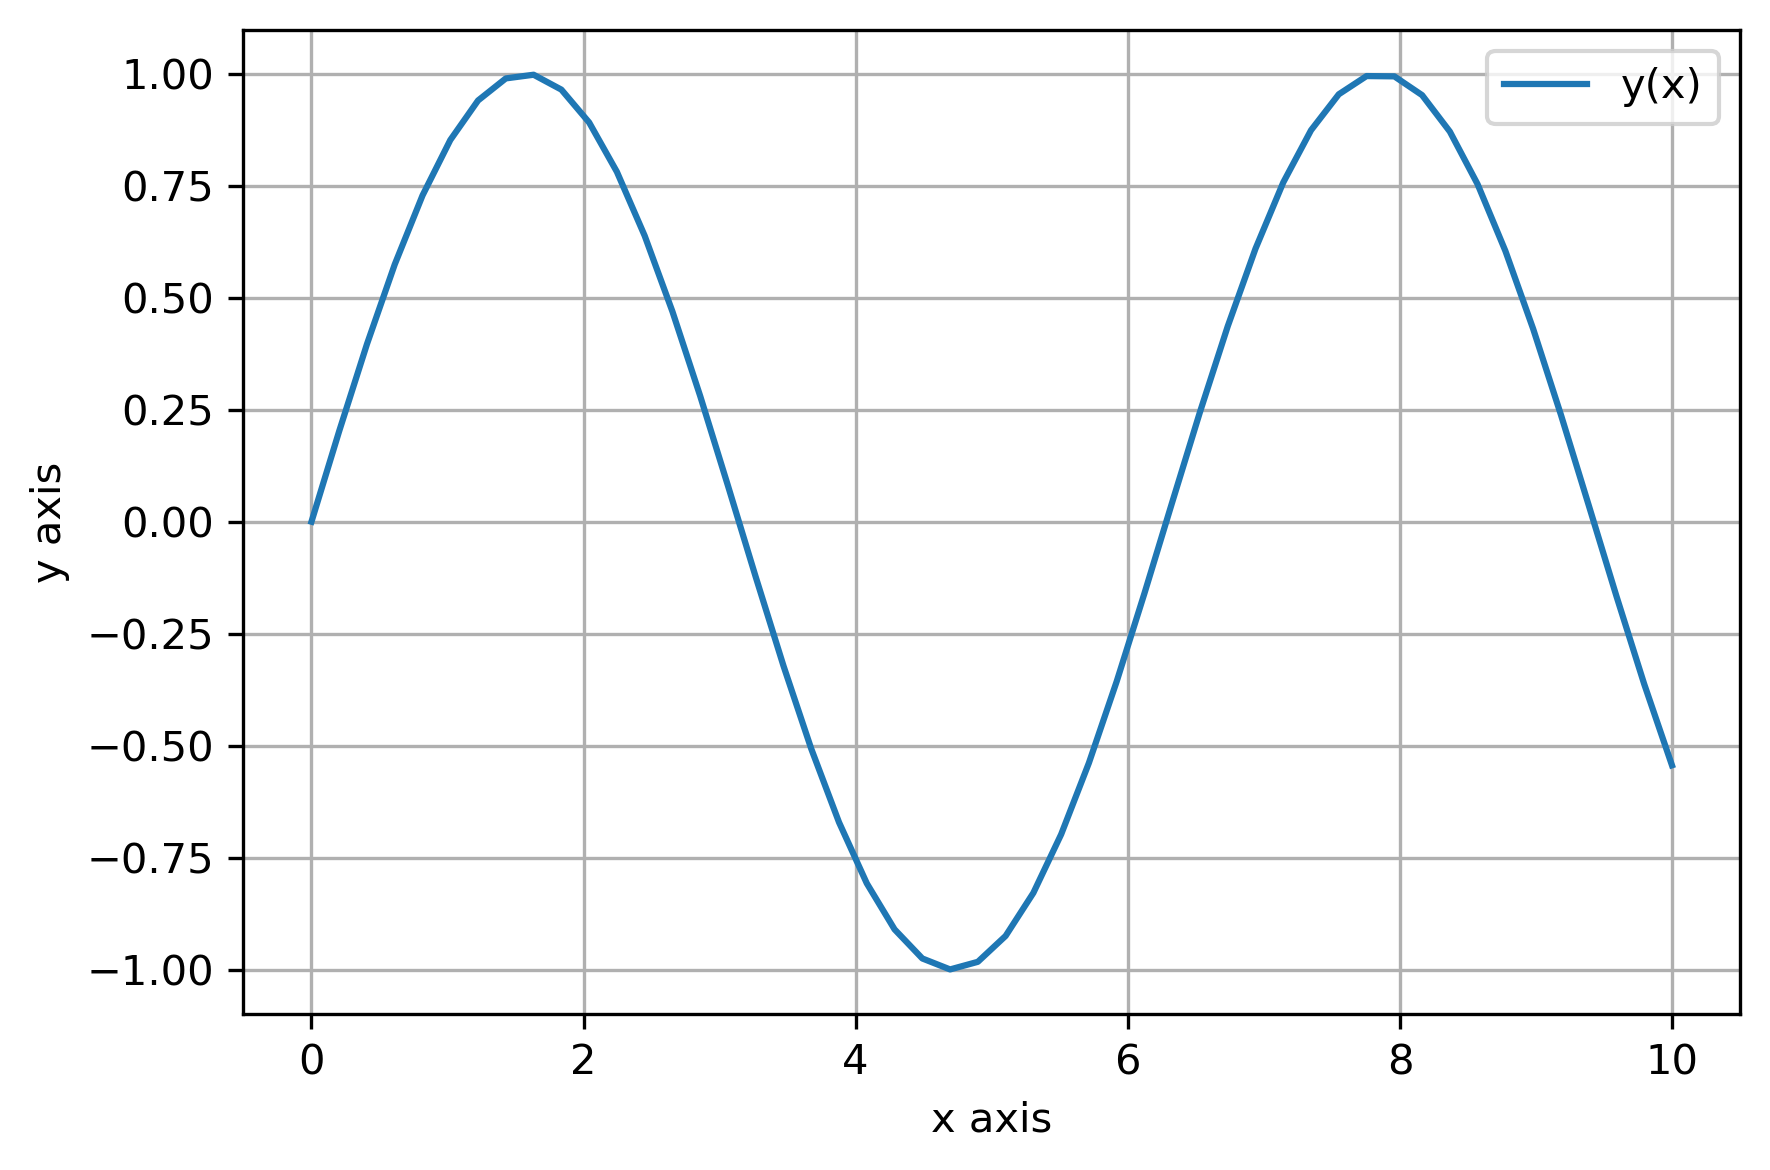

In [5]:
import numpy as np

x = np.linspace(0, 10, num=50, endpoint=True)
y = np.sin(x)

plt.plot(x, y, label='y(x)')
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We can also plot multiple data series in a single figure:

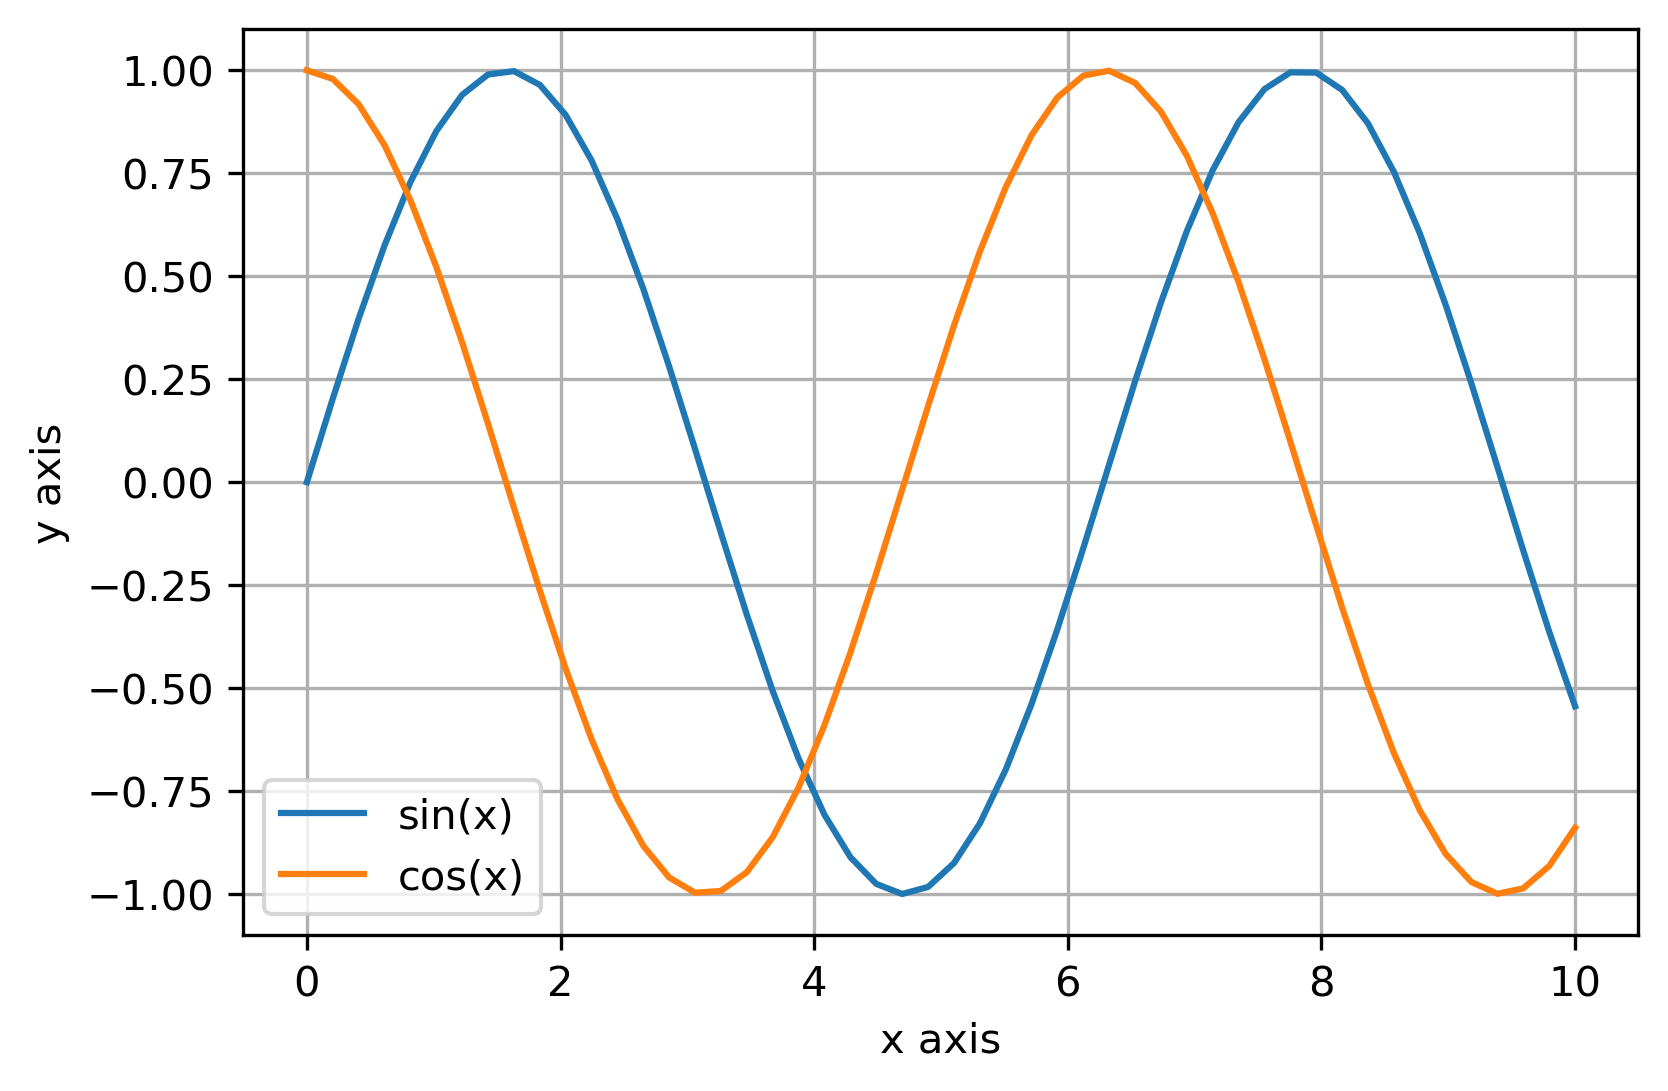

In [6]:
plt.plot(x, y, label='sin(x)')
plt.plot(x, np.cos(x), label='cos(x)')
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.grid(True)
plt.legend()
plt.show()

Or, we can use subplots to plot multiple axes in the same overall figure:

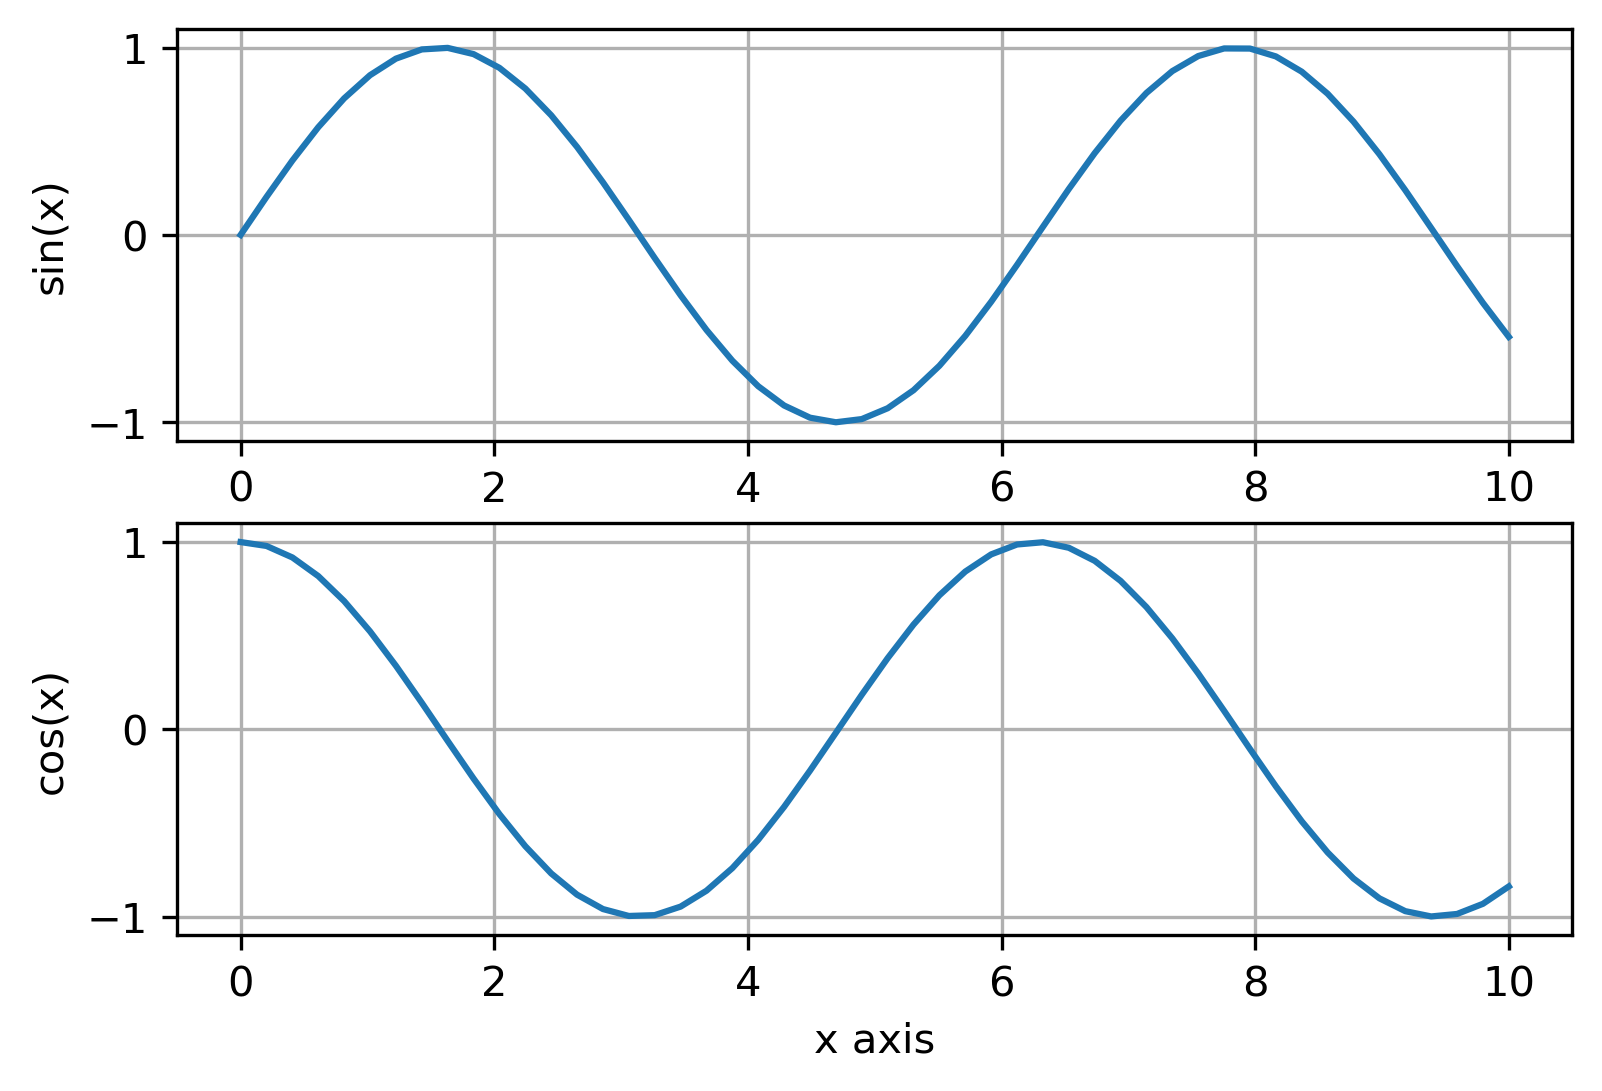

In [7]:
# 2 rows, 1 column
fig, axes = plt.subplots(2, 1)

axes[0].plot(x, y, label='sin(x)')
axes[0].set_ylabel('sin(x)')
axes[0].grid(True)

axes[1].plot(x, np.cos(x), label='cos(x)')
axes[1].set_xlabel('x axis')
axes[1].set_ylabel('cos(x)')
axes[1].grid(True)

plt.show()

## Solving systems of equations

Frequently we will encounter a system of one or more equations that involves an equal number of unknowns. If this is a linear system of equations, we can use linear algebra and the NumPy [`linalg.solve()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html) function, but more often in thermodynamics we encounter complex and/or nonlinear systems.

In cases like this, we will need to set up our problems to find the roots, or zeroes, of the function(s); in other words, given a function $ f(x) $, finding the root means to find the value of $x$ such that $ f(x) = 0 $. If we are dealing with a system of equations and the same number of unknowns, then these would be vectors: $\mathbf{f}(\mathbf{x}) = 0$.

(You might be wondering what to do about equations that don't equal zero... for example, if you have something like $f(x) = g(x)$. In this case, you just need to manipulate the equation to be in the form $f(x) - g(x) = 0$.)

The [SciPy optimization module](https://docs.scipy.org/doc/scipy/reference/optimize.html) provides functions to find roots of equations; for scalar equations, we can use [`root_scalar()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html#scipy.optimize.root_scalar), and for vector equations, we can use [`root()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html).

### Scalar equations 

Let's first look at an example of a scalar function: one equation, one unknown.

Find the root of this equation:
\begin{equation}
\cos(x) = x^3
\end{equation}

We need to create a Python function that returns $f(x) = 0$, so that the function returns zero when the input value of $x$ is the (correct) root. Then, we can use the `root_scalar` function with some initial guesses.

In [8]:
import numpy as np
from scipy import optimize

def func(x):
    return np.cos(x) - x**3

sol = optimize.root_scalar(func, x0=1.0, x1=2.0)

print(f'Root: x ={sol.root: .3f}')

print(f'Function evaluated at root: {func(sol.root)}')

Root: x = 0.865
Function evaluated at root: -2.220446049250313e-16


### Systems of equations / vector functions

We can also solve systems of equations in a similar fashion using the SciPy [`root()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html) functino, where we find the roots $\mathbf{x}$ that satisfy $\mathbf{f} (\mathbf{x}) = 0$.

For example, let's try to find the values of $x$ and $y$ that satisfy these equations:

$$
\begin{align*}
x \ln (x) &= y^3 \\
\sqrt{x} &= \frac{1}{y}
\end{align*}
$$

We have two equations and two unknowns, so we should be able to find the roots.

To solve, we create a function that evaluates these equations when made equal to zero, or

$$
\begin{align*}
x \ln (x) - y^3 &= 0 \\
\sqrt{x} - \frac{1}{y} &= 0
\end{align*}
$$

then we call `root` specifying this function and two initial guesses for $x$ and $y$:

In [9]:
import numpy as np
from scipy import optimize

def system(vars):
    x = vars[0]
    y = vars[1]
    
    return [
        x*np.log(x) - y**3,
        np.sqrt(x) - (1/y)
        ]

sol = optimize.root(system, [1.0, 1.0])

x = sol.x[0]
y = sol.x[1]

print(f'Roots: x = {x: .3f}, y = {y: .3f}')

Roots: x =  1.467, y =  0.826


## Integrating ODE systems

In some cases, we encounter problems that require integrating one or more ordinary different equations in time. Depending on the form of the problem, we may need to integrate a function between two points (definite integral), or we may have a system of ordinary differential equations.

### Numerical integral of samples

In some cases we have a set of $(x,y)$ data that we want to integrate numerically.
We can do this using the NumPy [`trapz()` function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.trapz.html), which implements the composite trapezoidal rule.

For example, let's consider a situation where a reciprocating compressor is being used to compress ammonia vapor during a refrigeration cycle. We have some experimental measurements of the pressure-volume data during the compression stroke (see table), and we want to determine the work done on the ammonia by the piston.

| Pressure (psi) | Volume (in^3) |
|----------------|---------------|
| 65.1           | 80.0          |
| 80.5           | 67.2          |
| 93.2           | 60.1          |
| 110            | 52.5          |
| 134            | 44.8          |
| 161            | 37.6          |
| 190            | 32.5          |

To find the work done by the piston to the ammonia, we can integrate pressure with respect to volume:
\begin{equation}
W_{\text{in}} = -\int_{V_1}^{V_2} P \, dV
\end{equation}

In [29]:
import numpy as np

pressure = Q_([65.1, 80.5, 93.2, 110, 134, 161, 190], 'psi')
volume = Q_([80.0, 67.2, 60.1, 52.5, 44.8, 37.6, 32.5], 'in^3')

# convert to SI units
pressure.ito('Pa')
volume.ito('m^3')

work = -Q_(
    np.trapz(pressure.magnitude, volume.magnitude), 
    pressure.units * volume.units
    )
print(f'Work done on fluid: {work.to("J"): .2f}')

Work done on fluid: 589.45 joule


```{margin}
Notice the use of the `.ito()` methods, which convert the units of a quantity in place.
```

We can also numerically integrate expressions/functions using the SciPy [`quad()` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html), also in the `integrate` module.

Let's build on the previous example: first, let's fit the compressor data to the polytropic form $P V^n = c$, where $c$ and $n$ are constants, then we can integrate the resulting function to calculate work.

To fit the data, we need to rearrange the equation to the form $y = f(x)$:
\begin{equation}
P = c V^{-n}
\end{equation}
We'll use the [`scipy.optimize.curve_fit()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) function for that.

In [30]:
# for convenience:
def to_si(quant):
    '''Converts a Pint Quantity to magnitude at base SI units.
    '''
    return quant.to_base_units().magnitude

In [32]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import quad

from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity

pressure = Q_([65.1, 80.5, 93.2, 110, 134, 161, 190], 'psi')
volume = Q_([80.0, 67.2, 60.1, 52.5, 44.8, 37.6, 32.5], 'in^3')

def fit(V, n, c):
    '''Evaluate P = c * V**(-n). 
    
    n and c will be found by the curve_fit functino.
    '''
    return c * np.power(V, -n)

# this function will automatically fit the unknown constants
params, cov = curve_fit(fit, to_si(volume), to_si(pressure))

print(f'Parameters: n={params[0]: 5.3f}, c={params[1]: 5.3f}')

Parameters: n= 1.170, c= 194.200


/var/folders/ng/d9rd9fb92c7bxz9fy7vwpj7m0000gp/T/ipykernel_19059/1606160274.py:17: RuntimeWarning: overflow encountered in power
  return c * np.power(V, -n)


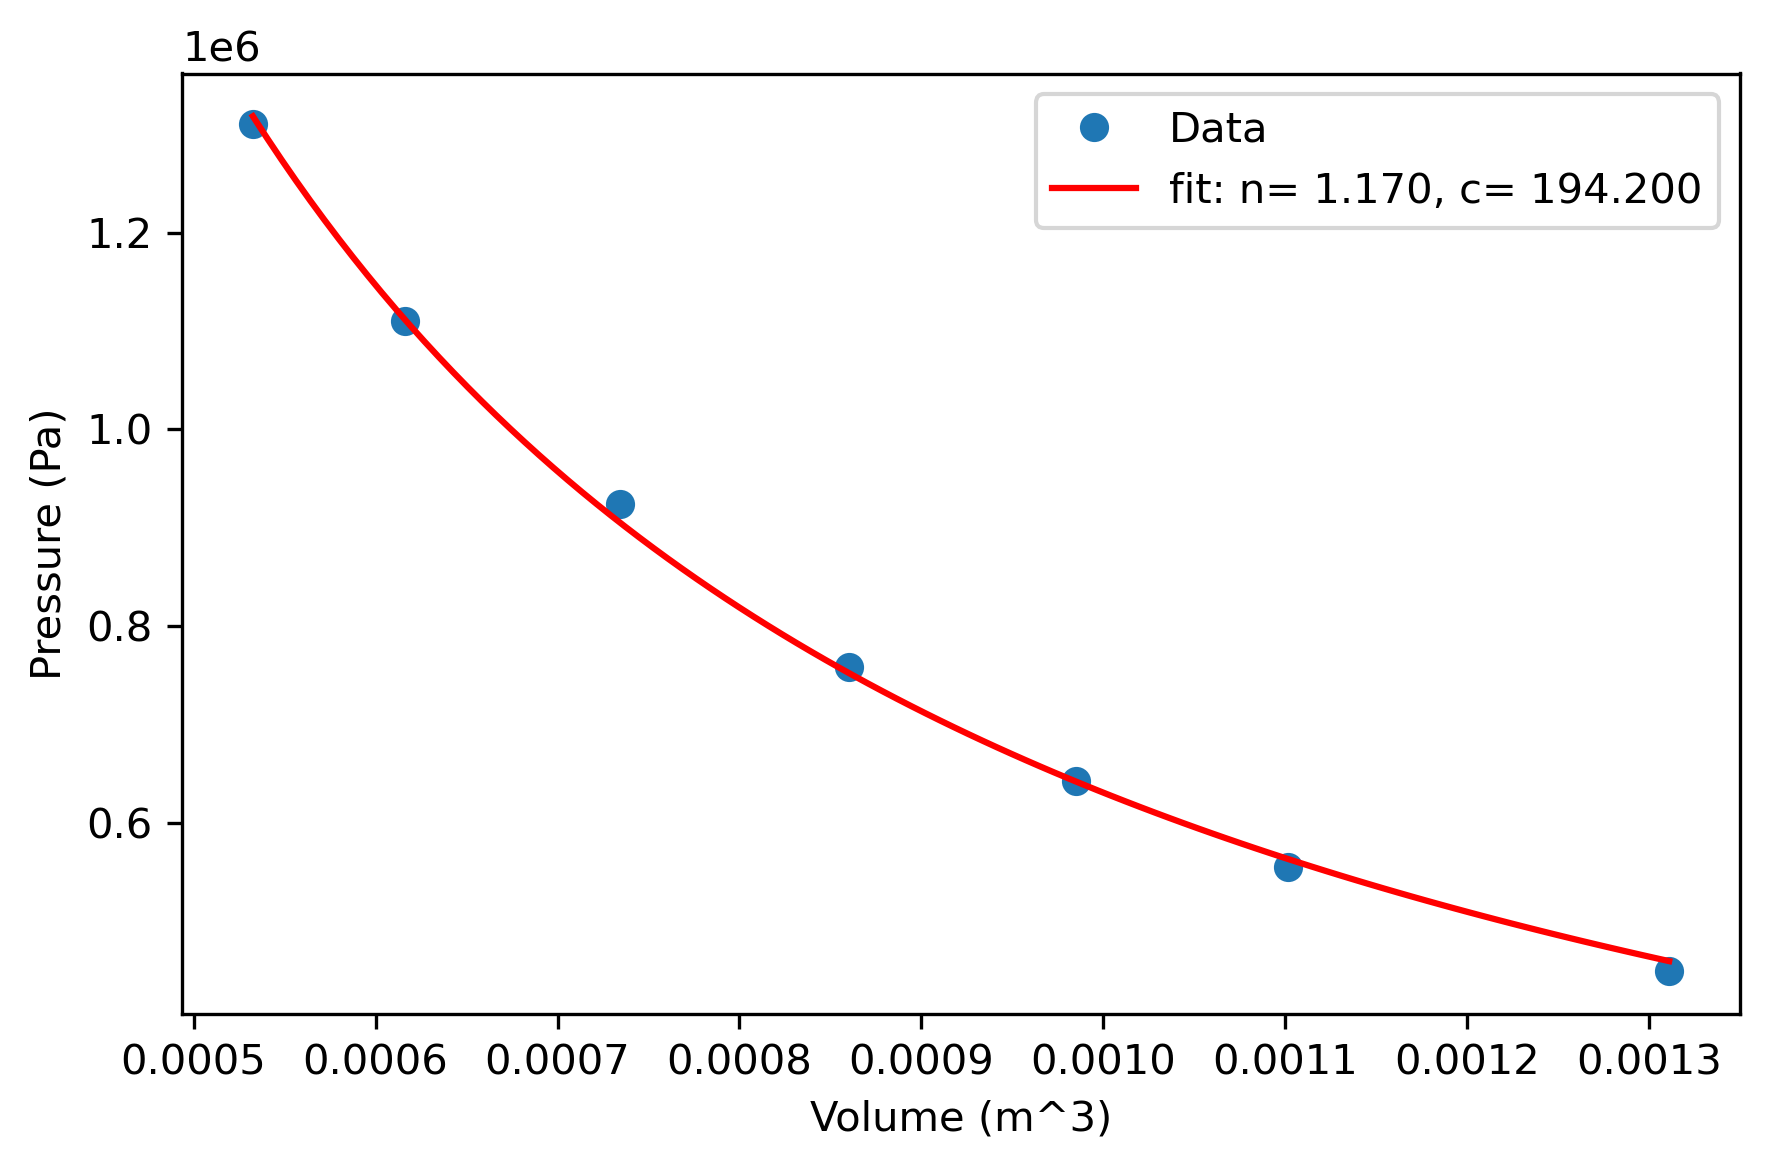

In [34]:
plt.plot(to_si(volume), to_si(pressure), 'o', label='Data')

x = np.linspace(to_si(volume[0]), to_si(volume[-1]), 100)

# plot data and fit
plt.plot(x, fit(x, *params), 'r-',
         label=f'fit: n={params[0]: 5.3f}, c={params[1]: 5.3f}'
         )
plt.xlabel('Volume (m^3)')
plt.ylabel('Pressure (Pa)')
plt.legend()
plt.tight_layout()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

That looks like a great fit to the data, so now let's evaluate the work by integrating:

In [37]:
y, err = quad(
    fit, to_si(volume[0]), to_si(volume[-1]), 
    args=(params[0], params[1])
    )

work = -Q_(y, 'J')

print(f'Work done on fluid: {work.to("J"): .2f}')

Work done on fluid: 586.26 joule


### Initial value problems

In other words, we may have a system like
\begin{equation}
\frac{d \mathbf{y}}{dt} = \mathbf{f} (t, \mathbf{y})
\end{equation}
where $\mathbf{y}$ is the vector of state variables, for which we should have the initial values ($\mathbf{y}(t=0)$). In this case, we can use the SciPy function [`solve_ivp()` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html), part of the `integrate` module.

For example, let's consider a problem where we want to find the volume of water, volume of air, and pressure in a tank as a function of time, as the tank releases water to an environment. The volumetric flow rate through the tank's valve is based on its instantaneous pressure:

$$
\dot{V}_f = \frac{P - P_{\text{atm}}}{R_v} \;,
$$

where $P_{\text{atm}}$ is atmospheric pressure and $R_v = 10$ psi/gpm is the valve resistance parameter. The tank has volume 50 gal, and is initially filled with water (volume fraction $f$ = 0.8); the air in the tank is initially at 100 psi. We will treat the air as an ideal gas, and the water as an incompressible substance.

We have the initial air pressure, and we can calculate the initial volumes of water and air:

$$
\begin{align*}
V_{f,0} &= f \, V \\
V_{g,0} &= (1 - f) V
\end{align*}
$$

We can perform a mass balance on the water in the tank to obtain a rate equation for the volume of water:

$$
\begin{align*}
0 &= \dot{m}_f + \frac{d m_f}{dt} = \dot{V}_f \rho_f + \rho_f \frac{d V_f}{dt} \\
0 &= \dot{V}_f + \frac{dV_f}{dt} \\
\therefore \frac{dV_f}{dt} &= -\frac{(P - P_{\text{atm}})}{R_v}
\end{align*}
$$

Since the overall volume of the tank is constant, we can obtain the rate of change of the volume of air:

$$
\begin{gather*}
V = V_g + V_f \\
\frac{dV_g}{dt} + \frac{dV_f}{dt} = 0 \\
\therefore \frac{dV_g}{dt} = -\frac{dV_f}{dt}
\end{gather*}
$$

Finally, a mass balance on the air in the tank allows us to find the rate of change of pressure:

$$
\begin{align*}
0 &= \frac{dm_a}{dt} \\
0 &= \frac{d}{dt} \left( \frac{P V_g}{R T} \right) \\
0 &= V_g \frac{dP}{dt} + P \frac{dV_g}{dt} \\
\therefore \frac{dP}{dt} &= -\frac{P}{V_g} \frac{dV_g}{dt}
\end{align*}
$$

Now, we can integrate this system of ODEs:

In [38]:
from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity

# initial conditions and constants
valve_resistance = Q_(10, 'psi/(gal/min)')
pressure_atmosphere = Q_(1, 'atm')

volume_tank = Q_(50, 'gal')
water_fraction = 0.8

pressure_initial = Q_(100, 'psi')
volume_water_initial = water_fraction * volume_tank
volume_air_initial = (1.0 - water_fraction) * volume_tank

In [39]:
def tank_equations(t, y, valve_resistance, pressure_atmosphere):
    '''Rates of change for water volume, air volume, and air pressure in tank.
    
    Input values in SI units.
    '''
    volume_water = Q_(y[0], 'm^3')
    volume_air = Q_(y[1], 'm^3')
    pressure_air = Q_(y[2], 'Pa')
    
    dVf_dt = -(pressure_air - pressure_atmosphere) / valve_resistance
    dVg_dt = -dVf_dt
    dP_dt = -(pressure_air / volume_air) * dVg_dt
    
    return [
        to_si(dVf_dt), 
        to_si(dVg_dt),
        to_si(dP_dt)
        ]

Now that we have the initial conditions and rate function set up, we can integrate in time. Let's do this for 500 seconds, and then plot the water volume and tank pressure as functions of time:

In [40]:
from scipy.integrate import solve_ivp

# now integrate for 500 seconds, specifying the function, time interval, 
#initial conditions, and additional arguments to the function

sol = solve_ivp(
    tank_equations, [0, 500.0],
    [to_si(volume_water_initial), 
     to_si(volume_air_initial), 
     to_si(pressure_initial)
     ],
    args=(valve_resistance, pressure_atmosphere,),
    method='BDF'
    )

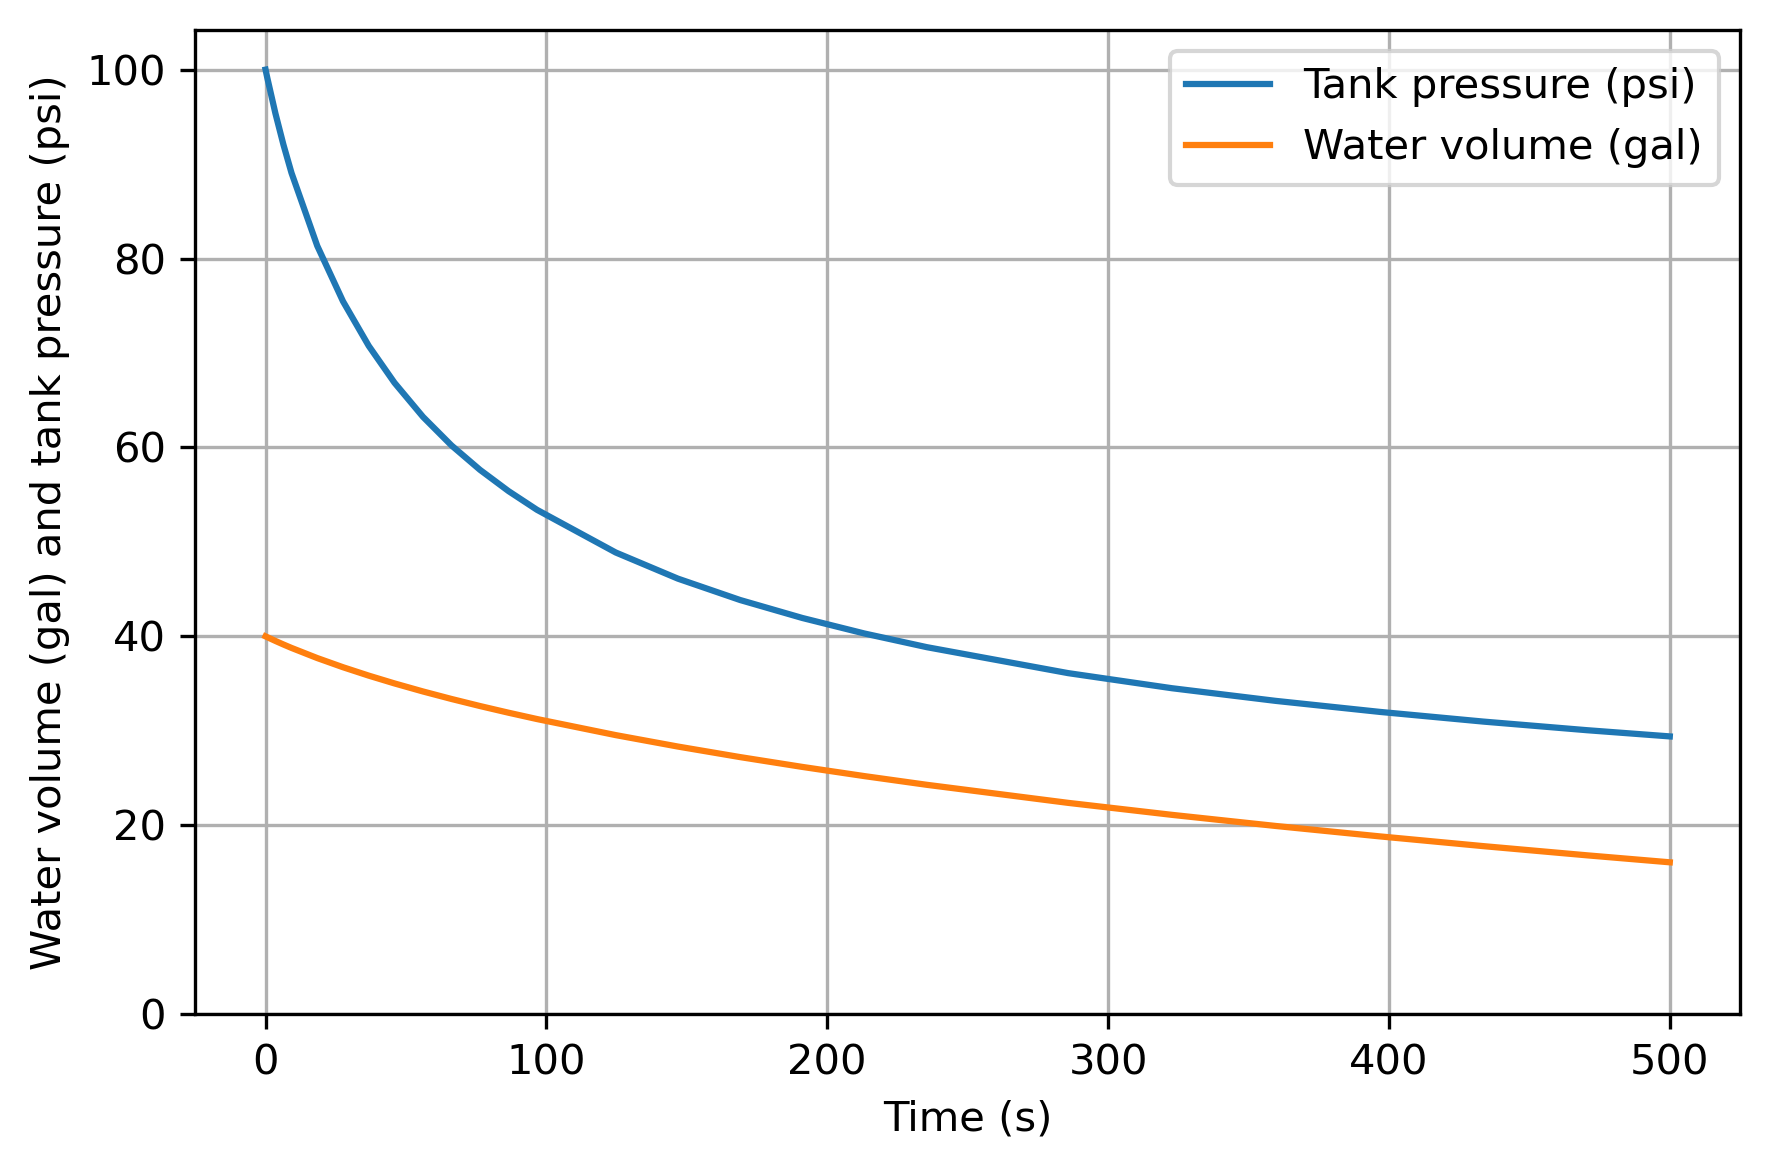

In [41]:
time = sol.t
volume_water = Q_(sol.y[0], 'm^3')
volume_air = Q_(sol.y[1], 'm^3')
pressure = Q_(sol.y[2], 'Pa')

plt.plot(time, pressure.to('psi').magnitude, label='Tank pressure (psi)')
plt.plot(time, volume_water.to('gal').magnitude, label='Water volume (gal)')
plt.grid(True)
plt.xlabel('Time (s)')
plt.ylabel('Water volume (gal) and tank pressure (psi)')
plt.ylim(ymin=0.0) # ensure lower y-axis bound is zero
plt.legend()
plt.tight_layout()
plt.show()